In [137]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import *
import numpy as np
from pylab import *
from numpy import ma
%matplotlib inline

In [138]:
#Domain size and constant parameters
Lx=1.0; Ly=1.0
gx=0.0; gy=-100.0;
rho1=1.0; rho2=2.0
m0=0.01;
rro=rho1;
nu=1.0;

#Velocity at wall boundary
unorth=0; usouth=0; veast=0; vwest=0; 

#Initial drop size and location
time=0.0; rad=0.15; xc=0.5; yc=0.7;

#Numerical variables
nx=32; ny=32;
dt=0.0025; nstep=100
maxiter=200; maxError=0.001
beta=1.2;

#Set the grid
dx=Lx/nx; dy=Ly/ny
x=np.linspace(-dx/2,(nx+0.5)*dx,nx+2)
y=np.linspace(-dy/2,(ny+0.5)*dy,ny+2)
    
#Set density in domain and drop:
r=np.ones((nx+2,ny+2))*rho1
for i in range(1,nx+1):
    for j in range (1,ny+1):
        if ((x[i]-xc)**2+(y[i]-yc)**2)<rad**2:
            r[i,j]=rho2;
    
#Zero arrays
u=np.zeros((nx+1,ny+2)); v=np.zeros((nx+2,ny+1)); p=np.zeros((nx+2,ny+2))
ut=np.zeros((nx+1,ny+2)); vt=np.zeros((nx+2,ny+1)); tmp1=np.zeros((nx+2,ny+2));
uu=np.zeros((nx+1,ny+1)); vv=np.zeros((nx+1,ny+1)); tmp2=np.zeros((nx+2,ny+2))


In [139]:
#Setup the front
Nf=100;
xf=np.zeros((Nf+2)); yf=np.zeros((Nf+2))

for i in range(Nf+1):
    xf[i]=xc-rad*sin(2.0*np.pi*i/Nf);
    yf[i]=yc+rad*cos(2.0*np.pi*i/Nf);

In [140]:
#Start the time loop
for steps in range (nstep):
    fx=np.zeros((nx+2,ny+2)); fy=np.zeros((nx+2,ny+2))
    
    #Tangential at boundaries: (Dieter's code is not correct at the part u[:,-1])
    u[:,0]=2*usouth-u[:,1];u[:,nx+1]=2*unorth-u[:,ny];
    v[0,:]=2*vwest-v[1,:];v[ny+1,:]=2*veast-v[nx,:];
    
    #Temporary u-velocity
    ut[1:-1,1:-1]=u[1:-1,1:-1]+dt*(-0.25*(((u[2:,1:-1]+u[1:-1,1:-1])**2-(u[1:-1,1:-1]+u[0:-2,1:-1])**2)/dx+\
                                          ((u[1:-1,2:]+u[1:-1,1:-1])*(v[2:-1,1:]+v[1:-2,1:])-\
                                           (u[1:-1,1:-1]+u[1:-1,0:-2])*(v[2:-1,0:-1]+v[1:-2,0:-1]))/dy)+\
                                   m0/(0.5*(r[2:-1,1:-1]+r[1:-2,1:-1]))*\
                                   nu*((u[2:,1:-1]-2*u[1:-1,1:-1]+u[0:-2,1:-1])/(dx**2)+\
                                       (u[1:-1,2:]-2*u[1:-1,1:-1]+u[1:-1,0:-2])/(dy**2))+gx)
                   
    #Temporary v-velocity
    vt[1:-1,1:-1]=v[1:-1,1:-1]+dt*(-0.25*(((u[1:,2:-1]+u[1:,1:-2])*(v[2:,1:-1]+v[1:-1,1:-1])-\
                                           (u[0:-1,2:-1]+u[0:-1,1:-2])*(v[1:-1,1:-1]+v[0:-2,1:-1]))/dx+\
                                          ((v[1:-1,2:]+v[1:-1,1:-1])**2-(v[1:-1,1:-1]+v[1:-1,0:-2])**2)/dy)+\
                                   m0/(0.5*(r[1:-1,2:-1]+r[1:-1,1:-2]))*\
                                   nu*((v[2:,1:-1]-2*v[1:-1,1:-1]+v[0:-2,1:-1])/(dx**2)+\
                                       (v[1:-1,2:]-2*v[1:-1,1:-1]+v[1:-1,0:-2])/(dy**2))+gy)
                                       
    # Coefficient for p(i,j):
    rt=r.copy(); lrg=1000;
    rt[:,0]=lrg; rt[:,ny+1]=lrg;
    rt[0,:]=lrg; rt[nx+1,:]=lrg;
    
    tmp1[1:-1,1:-1]=(0.5/dt)*((ut[1:,1:-1]-ut[0:-1,1:-1])/dx+(vt[1:-1,1:]-vt[1:-1,0:-1])/dy)
    tmp2[1:-1,1:-1]=1.0/((1./dx)*(1./(dx*(rt[2:,1:-1]+rt[1:-1,1:-1]))+\
                                  1./(dx*(rt[0:-2,1:-1]+rt[1:-1,1:-1])))+\
                         (1./dy)*(1./(dy*(rt[1:-1,2:]+rt[1:-1,1:-1]))+\
                                 1./(dy*(rt[1:-1,0:-2]+rt[1:-1,1:-1]))))
    
    # Poisson solver for p:
    iter=0
    while True:
        pn=p.copy()
        iter=iter+1
        for i in range(1,nx+1):
            for j in range(1,ny+1):
                p[i,j]=(1.0-beta)*p[i,j]+beta*tmp2[i,j]*(\
                    (1./dx)*( p[i+1,j]/(dx*(rt[i+1,j]+rt[i,j]))+\
                    p[i-1,j]/(dx*(rt[i-1,j]+rt[i,j])))+\
                    (1./dy)*( p[i,j+1]/(dy*(rt[i,j+1]+rt[i,j]))+\
                    p[i,j-1]/(dy*(rt[i,j-1]+rt[i,j])))-tmp1[i,j])
        
        if np.abs(pn-p).max()<maxError:
            break
        if iter>maxiter:
            break
            
    #Calculate u-velocity:
    u[1:-1,1:-1]=ut[1:-1,1:-1]-dt*(2.0/dx)*(p[2:-1,1:-1]-p[1:-2,1:-1])/(r[2:-1,1:-1]+r[1:-2,1:-1])

    
    #Calculate v-velocity:
    v[1:-1,1:-1]=vt[1:-1,1:-1]-dt*(2.0/dy)*(p[1:-1,2:-1]-p[1:-1,1:-2])/(r[1:-1,2:-1]+r[1:-1,1:-2])


    #ADCVECT FRONT
    #Calculate front velocity:
    uf=np.zeros((Nf+2)); vf=np.zeros((Nf+2))
    
    for i in range (1,Nf):
        
        #Calculate x-component
        ip=floor(xf[i]/dx); jp=floor((yf[i]+0.5*dy)/dy);
        ax=xf[i]/dx-ip; ay=(yf[i]+0.5*dy)/dy-jp;
        uf[i]=(1.0-ax)*(1.0-ay)*u[ip,jp]+ax*(1.0-ay)*u[ip+1,jp]+(1.0-ax)*ay*u[ip,jp+1]+ax*ay*u[ip+1,jp+1]
        
        #Calculate y-component
        ip=floor((xf[i]+0.5*dx)/dx); jp=floor(yf[i]/dy)
        ax=(xf[i]+0.5*dx)/dx-ip;ay=yf[i]/dy-jp
        vf[i]=(1.0-ax)*(1.0-ay)*v[ip,jp]+ax*(1.0-ay)*v[ip+1,jp]+(1.0-ax)*ay*v[ip,jp+1]+ax*ay*v[ip+1,jp+1]
     
    #Move the front:
    for i in range (1,Nf):
        xf[i]=xf[i]+uf[i]*dt;yf[i]=yf[i]+vf[i]*dt
        
    xf[0]=xf[Nf]; yf[0]=yf[Nf]; xf[Nf+1]=xf[1]; yf[Nf+1]=yf[1]
    
    # Add points to the front
    xfold=xf.copy(); yfold=yf.copy(); j=0;
    xf1=[]; xf1.append(xf[0]);
    yf1=[]; yf1.append(yf[0]);
    for i in range (1,Nf):
        ds=sqrt(((xfold[i]-xf1[j])/dx)**2+((yfold[i]-yf1[j])/dy)**2);
        if ds>0.5:
            j=j+1;xf1.append(0.5*(xfold[i]+xf1[j-1]));yf1.append(0.5*(yfold[i]+yf1[j-1]))
            j=j+1;xf1.append(xfold[i]);yf1.append(yfold[i])
        elif ds>0.25:
            j=j+1;xf1.append(xfold[i]);yf1.append(yfold[i])
    
    Nf=j-1; xf=np.asarray(xf1);yf=np.asarray(yf1)
    xf[0]=xf[Nf];yf[0]=yf[Nf]
    xf[Nf+1]=xf[1];yf[Nf+1]=yf[1]
    
    #Distribute gradient:
    fx=np.zeros((nx+2,nx+2)); fy=np.zeros((nx+2,ny+2))
    for i in range (1,Nf):
        nfx=-0.5*(yf[i+1]-yf[i-1])*(rho2-rho1)
        nfy=0.5*(xf[i+1]-xf[i-1])*(rho2-rho1)
        
        ip=floor(xf[i]/dx); jp=floor((yf[i]+0.5*dy)/dy);
        ax=xf[i]/dx-ip; ay=(yf[i]+0.5*dy)/dy-jp;
        fx[ip,jp] =fx[ip,jp]+(1.0-ax)*(1.0-ay)*nfx/dx/dy;
        fx[ip+1,jp] =fx[ip+1,jp]+ax*(1.0-ay)*nfx/dx/dy;
        fx[ip,jp+1] =fx[ip,jp+1]+(1.0-ax)*ay*nfx/dx/dy;
        fx[ip+1,jp+1]=fx[ip+1,jp+1]+ax*ay*nfx/dx/dy;
        
        ip=floor((xf[i]+0.5*dx)/dx); jp=floor(yf[i]/dy);
        ax=(xf[i]+0.5*dx)/dx-ip; ay=yf[i]/dy-jp;
        fy[ip,jp] =fy[ip,jp]+(1.0-ax)*(1.0-ay)*nfy/dx/dy;
        fy[ip+1,jp] =fy[ip+1,jp]+ax*(1.0-ay)*nfy/dx/dy;
        fy[ip,jp+1] =fy[ip,jp+1]+(1.0-ax)*ay*nfy/dx/dy;
        fy[ip+1,jp+1]=fy[ip+1,jp+1]+ax*ay*nfy/dx/dy;
        
    #Construct the density
    iter=0
    while True:
        rt=r.copy()
        iter=iter+1
        r[1:-1,1:-1]=0.25*(r[2:,1:-1]+r[0:-2,1:-1]+r[1:-1,2:]+r[1:-1,0:-2]+
                          dx*(fx[0:-2,1:-1]-fx[1:-1,1:-1])+ dy*(fy[1:-1,0:-2]-fy[1:-1,2:]))
        if np.abs(rt-r).max()<maxError:
            break
        if iter>maxiter:
            break
            

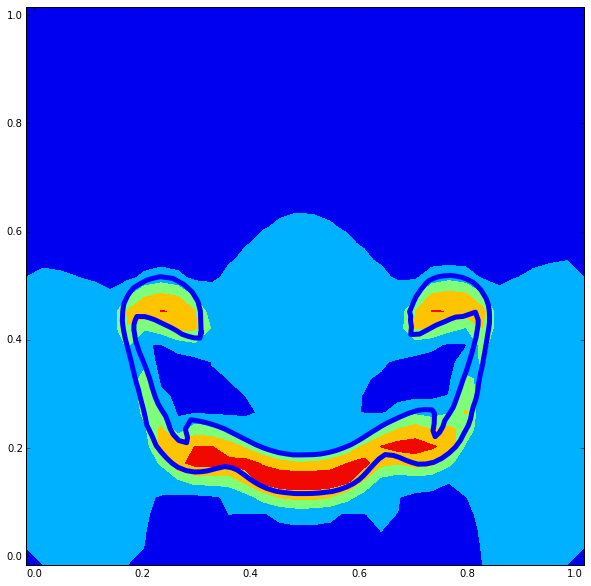

In [141]:
fig = plt.figure(figsize=(10,10), dpi=300)
uu=0.5*(u[0:nx,1:ny+1]+u[0:nx,0:ny])
vv=0.5*(v[1:nx+1,0:ny]+v[0:nx,0:ny])
yy,xx=np.mgrid[0:(nx-1)*dx:nx*1j,0:(ny-1)*dx:ny*1j]
plt.clf()
plt.quiver(xx,yy,uu.T,vv.T)
plt.contourf(x,y,r.T,5)
plt.plot(xf[0:Nf+1], yf[0:Nf+1],linewidth=5.0)